In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# Maze Layout
maze = np.array([
    [ 'S','0','1','0','0','0'],
    [ '0','0','1','0','1','0'],
    [ '0','0','0','0','1','0'],
    [ '0','1','1','0','0','0'],
    [ '0','0','0','1','0','G'],
])

n_rows, n_cols = maze.shape

In [9]:
# Convert to numeric grid
grid = np.zeros_like(maze, dtype=int)
for r in range(n_rows):
    for c in range(n_cols):
        if maze[r,c] == '1':
            grid[r,c] = 1
        elif maze[r,c] == 'S':
            start = (r,c)
        elif maze[r,c] == 'G':
            goal = (r,c)

In [11]:
# Maze environment class
class MazeEnv:
    def __init__(self, grid, start, goal, step_reward=-0.01, goal_reward=1.0, max_steps=200):
        self.grid = grid
        self.start = start
        self.goal = goal
        self.step_reward = step_reward
        self.goal_reward = goal_reward
        self.max_steps = max_steps
        self.n_rows, self.n_cols = grid.shape
        self.actions = [(-1,0),(1,0),(0,-1),(0,1)]
        self.n_actions = len(self.actions)
        self.reset()
        
    def state_to_idx(self, s):
        return s[0]*self.n_cols + s[1]
    
    def idx_to_state(self, idx):
        return (idx // self.n_cols, idx % self.n_cols)
    
    def reset(self):
        self.pos = self.start
        self.steps = 0
        return self.state_to_idx(self.pos)
    
    def step(self, action):
        dr, dc = self.actions[action]
        nr, nc = self.pos[0] + dr, self.pos[1] + dc
        self.steps += 1
        if nr < 0 or nr >= self.n_rows or nc < 0 or nc >= self.n_cols or self.grid[nr,nc] == 1:
            reward = self.step_reward - 0.05
            done = False
            next_state = self.state_to_idx(self.pos)
            if self.steps >= self.max_steps:
                done = True
            return next_state, reward, done, {}
        else:
            self.pos = (nr,nc)
            if self.pos == self.goal:
                return self.state_to_idx(self.pos), self.goal_reward, True, {}
            else:
                done = (self.steps >= self.max_steps)
                return self.state_to_idx(self.pos), self.step_reward, done, {}
    
    def render(self, policy=None, path=None):
        fig, ax = plt.subplots(figsize=(6,5))
        ax.set_title("Maze Environment")
        ax.set_xticks(np.arange(-0.5, self.n_cols, 1))
        ax.set_yticks(np.arange(-0.5, self.n_rows, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)
        ax.invert_yaxis()
        for r in range(self.n_rows):
            for c in range(self.n_cols):
                if self.grid[r,c] == 1:
                    ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1,1))
        ax.text(self.start[1], self.start[0], 'S', va='center', ha='center', fontsize=14, fontweight='bold')
        ax.text(self.goal[1], self.goal[0], 'G', va='center', ha='center', fontsize=14, fontweight='bold')
        if policy is not None:
            action_to_arrow = {0:'↑',1:'↓',2:'←',3:'→'}
            for idx, a in enumerate(policy):
                r,c = idx // self.n_cols, idx % self.n_cols
                if self.grid[r,c] == 0 and (r,c) != self.goal:
                    ax.text(c, r, action_to_arrow[a], va='center', ha='center', fontsize=12)
        if path is not None:
            pr = [p[0] for p in path]
            pc = [p[1] for p in path]
            ax.plot(pc, pr, linewidth=2)
            ax.scatter([pc[0]],[pr[0]],marker='o')
            ax.scatter([pc[-1]],[pr[-1]],marker='x')
        plt.show()


In [13]:
# Initialize environment
env = MazeEnv(grid, start, goal)

n_states = env.n_rows * env.n_cols
Q = np.zeros((n_states, env.n_actions))

In [15]:
# Q-learning parameters
alpha = 0.5
gamma = 0.99
epsilon = 0.2
n_episodes = 2000
max_steps_per_episode = 200

rewards_all = []


In [17]:
# Training loop
for ep in range(n_episodes):
    s = env.reset()
    total_reward = 0.0
    for step in range(max_steps_per_episode):
        if np.random.rand() < epsilon:
            a = np.random.randint(env.n_actions)
        else:
            a = np.argmax(Q[s])
        ns, r, done, _ = env.step(a)
        total_reward += r
        Q[s,a] = Q[s,a] + alpha * (r + gamma * np.max(Q[ns]) - Q[s,a])
        s = ns
        if done:
            break
    if ep % 100 == 0 and ep > 0:
        epsilon = max(0.02, epsilon * 0.95)
    rewards_all.append(total_reward)


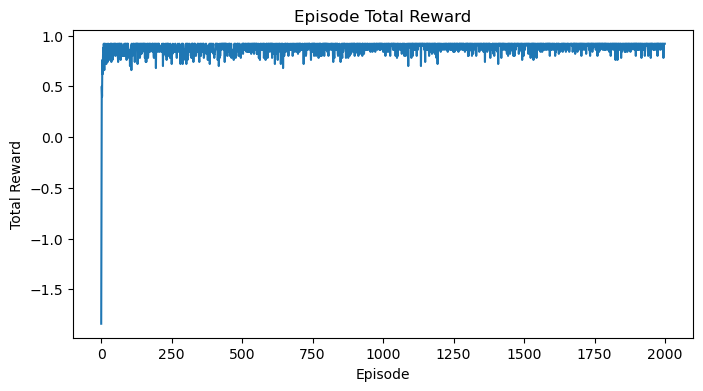

In [19]:
# Plot training reward curve
plt.figure(figsize=(8,4))
plt.plot(rewards_all)
plt.title("Episode Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()


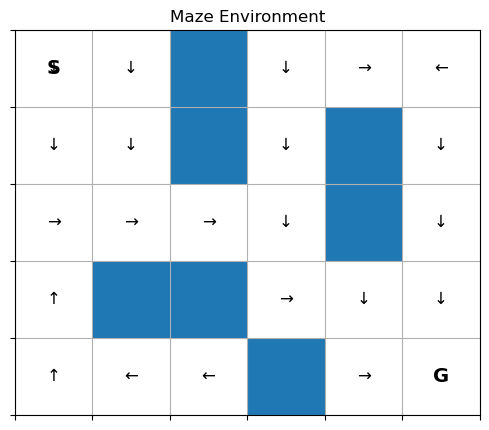

In [21]:
# Greedy policy and visualization
policy = np.argmax(Q, axis=1)
env.render(policy=policy)

Sample greedy path: [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (4, 5)]


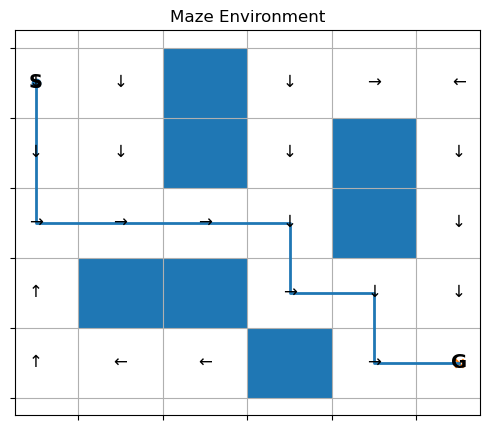

In [23]:
# Extract path
def follow_policy(start, policy, env, max_steps=200):
    pos = start
    path = [pos]
    visited = set([pos])
    for _ in range(max_steps):
        sidx = env.state_to_idx(pos)
        a = int(policy[sidx])
        dr, dc = env.actions[a]
        nr, nc = pos[0] + dr, pos[1] + dc
        if nr < 0 or nr >= env.n_rows or nc < 0 or nc >= env.n_cols or env.grid[nr,nc] == 1:
            break
        pos = (nr,nc)
        path.append(pos)
        if pos == env.goal:
            break
        if pos in visited:
            break
        visited.add(pos)
    return path

path = follow_policy(start, policy, env)
print("Sample greedy path:", path)
env.render(path=path, policy=policy)


In [25]:
# Q-table summary
rows = []
for idx in range(n_states):
    r,c = idx // env.n_cols, idx % env.n_cols
    if env.grid[r,c] == 0:
        rows.append({
            'state_idx': idx,
            'pos': f"({r},{c})",
            'Q_up': round(Q[idx,0],3),
            'Q_down': round(Q[idx,1],3),
            'Q_left': round(Q[idx,2],3),
            'Q_right': round(Q[idx,3],3),
            'best_action': ['U','D','L','R'][int(np.argmax(Q[idx]))]
        })
df_q = pd.DataFrame(rows)
df_q.head(12)

,state_idx,pos,Q_up,Q_down,Q_left,Q_right,best_action
0,0,"(0,0)",0.777,0.845,0.777,0.845,D
1,1,"(0,1)",0.578,0.864,0.609,0.686,D
2,3,"(0,3)",-0.030,0.440,-0.030,-0.017,D
3,4,"(0,4)",-0.030,-0.030,-0.020,-0.012,R
4,5,"(0,5)",-0.045,-0.016,-0.012,-0.030,L
5,6,"(1,0)",0.827,0.864,0.795,0.864,D
6,7,"(1,1)",0.841,0.883,0.818,0.813,D
7,9,"(1,3)",-0.021,0.921,0.395,0.692,D
8,11,"(1,5)",-0.016,0.839,0.420,-0.030,D
9,12,"(2,0)",0.845,0.845,0.814,0.883,R


Optimal Path Learned:
S 0 1 0 0 0
. 0 1 0 1 0
. . . . 1 0
0 1 1 . . 0
0 0 0 1 . G


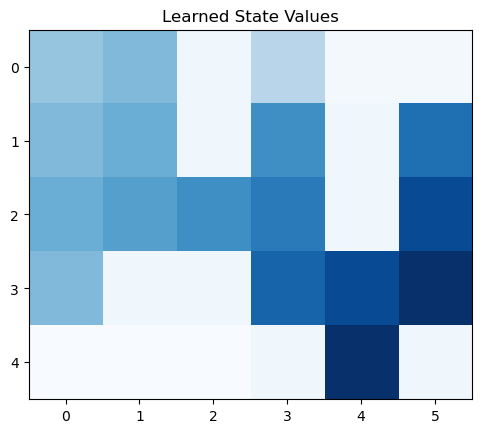

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Maze setup: 0=free, 1=wall, S=start, G=goal
maze = np.array([
    ['S','0','1','0','0','0'],
    ['0','0','1','0','1','0'],
    ['0','0','0','0','1','0'],
    ['0','1','1','0','0','0'],
    ['0','0','0','1','0','G']
])
n_rows, n_cols = maze.shape
grid = (maze == '1').astype(int)
start, goal = tuple(np.argwhere(maze == 'S')[0]), tuple(np.argwhere(maze == 'G')[0])

# Environment
class Maze:
    def __init__(self, grid, start, goal):
        self.grid, self.start, self.goal = grid, start, goal
        self.actions = [(-1,0),(1,0),(0,-1),(0,1)]  # up, down, left, right
        self.reset()
    def reset(self): self.pos = self.start; return self.state()
    def state(self): return self.pos[0]*grid.shape[1] + self.pos[1]
    def step(self, a):
        r, c = self.pos; dr, dc = self.actions[a]
        nr, nc = r+dr, c+dc
        if (nr<0 or nc<0 or nr>=grid.shape[0] or nc>=grid.shape[1] or grid[nr,nc]==1):
            return self.state(), -0.05, False
        self.pos = (nr,nc)
        if self.pos == self.goal: return self.state(), 1, True
        return self.state(), -0.01, False
    def render(self, path=[]):
        m = maze.copy()
        for (r,c) in path: 
            if m[r,c] not in ['S','G']: m[r,c]='.'
        print("\n".join(" ".join(row) for row in m))

env = Maze(grid, start, goal)

# Q-learning
Q = np.zeros((n_rows*n_cols, 4))
α, γ, ε, episodes = 0.5, 0.9, 0.2, 1000
for _ in range(episodes):
    s = env.reset()
    done = False
    while not done:
        a = np.random.randint(4) if np.random.rand() < ε else np.argmax(Q[s])
        ns, r, done = env.step(a)
        Q[s,a] += α*(r + γ*np.max(Q[ns]) - Q[s,a])
        s = ns

# Follow learned policy
s, path = env.reset(), [env.pos]
for _ in range(50):
    a = np.argmax(Q[s])
    s,_,done = env.step(a)
    path.append(env.pos)
    if done: break

print("Optimal Path Learned:")
env.render(path)

# Plot Q-value improvement (optional)
plt.imshow(np.max(Q,axis=1).reshape(n_rows,n_cols), cmap="Blues")
plt.title("Learned State Values")
plt.show()
